In [1]:
%pip install pythtb

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importing necessary libraries
from pythtb import *
import matplotlib.pyplot as plt

# Initializing the Wannier90 model by reading the data files
pgda=w90(r"Phosphorene",r"wannier90")   # Phosphorene/wannier90.win
my_model=pgda.model(min_hopping_norm=0.01) # only hoppings with norm greater than 0.01 are considered

In [2]:
# 2D finite difference velocity using dummy kz=0.0
def calculate_v_euler_forward_2D(k_vec, dk=0.01):
    kx, ky = k_vec
    kz = 0.0  # dummy kz

    H = my_model._gen_ham([kx, ky, kz])
    Hx = my_model._gen_ham([kx + dk, ky, kz])
    Hy = my_model._gen_ham([kx, ky + dk, kz])

    vx = (Hx - H) / dk
    vy = (Hy - H) / dk
    #print("shape of vx and vy :",vx.shape, vy.shape) 
    return np.array((vx, vy))


In [3]:
import numpy as np

def solve_and_calculate_Omega_xyz_2D(k_vec, eta=0.01):
    k_vec = np.array(k_vec)
    
    v = calculate_v_euler_forward_2D(k_vec)
    eig_values, eig_vectors = my_model.solve_one([k_vec[0], k_vec[1], 0.0], eig_vectors=True)

    num_bands = eig_values.shape[0]
    Lz = np.zeros(num_bands, dtype=complex)

    # Calculate Lz for each band
    for n in range(num_bands):
        psi_n = eig_vectors[:, n]  # (N,)
        temp = 0 + 0j
        for m in range(num_bands):
            if m == n:
                continue
            psi_m = eig_vectors[:, m]

            # term1 = (psi_n^† v_x psi_m) * (psi_m^† v_y psi_n)
            v_x_psi_m = np.dot(v[0], psi_m)                  # (N,)
            term1_part1 = np.dot(psi_n.conj().T, v_x_psi_m)  # scalar

            v_y_psi_n = np.dot(v[1], psi_n)                  # (N,)
            term1_part2 = np.dot(psi_m.conj().T, v_y_psi_n)  # scalar
            term1 = term1_part1 * term1_part2

            # term2 = (psi_n^† v_y psi_m) * (psi_m^† v_x psi_n)
            v_y_psi_m = np.dot(v[1], psi_m)
            term2_part1 = np.dot(psi_n.conj().T, v_y_psi_m)

            v_x_psi_n = np.dot(v[0], psi_n)
            term2_part2 = np.dot(psi_m.conj().T, v_x_psi_n)
            term2 = term2_part1 * term2_part2

            denom = eig_values[n] - eig_values[m] + 1j * eta
            temp += (term1 - term2) / denom

        Lz[n] = np.imag(temp)

    # Project Lz (which is a vector of length num_bands) into band basis
    # This was wrong in original: psi_n.conj().T @ Lz @ psi_n
    # Instead, weight Lz by the probability weights |psi_n|^2 of each component?
    # But psi_n is an eigenvector, Lz is per band, so usually no need for this projection again.
    # Assuming you want Lz as is for each band, skip or keep this as just Lz.

    # Berry curvature weighted by Lz
    Omega_xy = np.zeros(num_bands, dtype=float)
    for n in range(num_bands):
        psi_n = eig_vectors[:, n]
        temp = 0 + 0j
        for m in range(num_bands):
            if m == n:
                continue
            psi_m = eig_vectors[:, m]

            vnm_x = np.dot(psi_n.conj().T, np.dot(v[0], psi_m))
            vmn_y = np.dot(psi_m.conj().T, np.dot(v[1], psi_n))
            vnm_y = np.dot(psi_n.conj().T, np.dot(v[1], psi_m))
            vmn_x = np.dot(psi_m.conj().T, np.dot(v[0], psi_n))

            denom = (eig_values[n] - eig_values[m] + 1j * eta)**2

            temp -= (Lz[n] + Lz[m]) * (vnm_x * vmn_y - vnm_y * vmn_x) / denom
        Omega_xy[n] = np.imag(temp / 2)

    return eig_values, Omega_xy


In [16]:
from joblib import Parallel, delayed
import numpy as np

# Efficient computation of eigenvalues and Omega_xy using parallel processing (2D)
def parallel_solve_and_calculate_2D(k_points):
    num_bands = 24
    evals = np.zeros((num_bands, len(k_points)))
    Omega_xy = np.zeros((num_bands, len(k_points)))

    results = Parallel(n_jobs=-1)(
        delayed(solve_and_calculate_Omega_xyz_2D)(k_point) for k_point in k_points
    )

    for i, (e_vals, Omega) in enumerate(results):
        evals[:, i] = e_vals
        Omega_xy[:, i] = Omega

    return evals, Omega_xy

# Create 2D k-points
N = 50
kx = np.linspace(-0.5, 0.5, N, endpoint=False)
ky = np.linspace(-0.5, 0.5, N, endpoint=False)

# Create 2D meshgrid and flatten
kx_grid, ky_grid = np.meshgrid(kx, ky, indexing='ij')
k_points = np.vstack([kx_grid.ravel(), ky_grid.ravel()]).T  # shape (N², 2)

# Run parallel computation
evals, Omega_xy = parallel_solve_and_calculate_2D(k_points)


In [28]:
# Orbital Hall conductivity

# we need energies (eval) where we take u = 6.87 and omega_xyz which we have already computed
#print((evals))
def fermi_distribution(energies, T):
    KT = 26e-3
    y = 1/(1+np.exp((energies)/KT))
    return y


In [29]:
# using evals
u = np.linspace(-0.1,0.1,20)
response = []
for i in u:
  summation1 = fermi_distribution(evals-2.8123-i, 300)
  result = np.sum(summation1* Omega_xy)
  results = np.sum(result)
  results = results / (2 * np.pi)**2 / N**2 * 15.19
  response.append(results)
  print(results)

-10.324431442923336
-10.158875598670699
-8.568050810897992
-5.886918417916561
-2.712979536468129
0.38618118631607495
3.0501072970332337
5.14546385080727
6.70022566340433
7.827275387668726
8.669054366130295
9.362412821135223
10.016166557136174
10.701292158516168
11.455722405532214
12.297289435237523
13.23301391311171
14.259116809569528
15.356375400024682
16.48972296105206


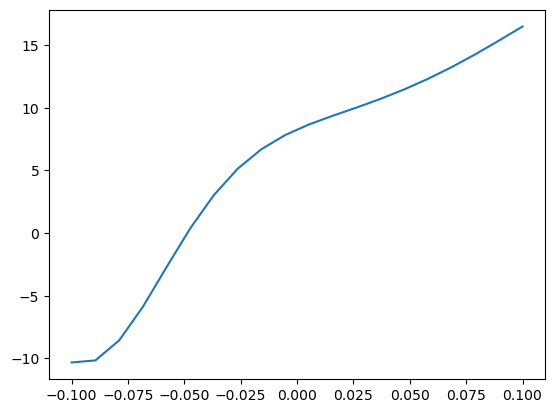

In [30]:
plt.plot(u,response)
plt.show()